# Northwind Traders

## Introduction

As a data scientist working for Northwind Traders, I have been tasked with drawing insights from a given database. In particular, I will seek to answer the following questions, which are of interest to stakeholders:

1. Do discounts have a statistically significant effect on the number of products customers order? And if so, at what level(s) of discount?
2. Do discounts have a statistically significant effect on the amount a customer spends on their order? And if so, at what level(s) of discount?
3. Does the average order amount vary significally between customers in different regions?

## Load DB

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import scipy.stats as stats 
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# Create an engine and connect to DB with SQLAlchemy
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

2020-12-28 10:30:53,435 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-28 10:30:53,436 INFO sqlalchemy.engine.base.Engine ()
2020-12-28 10:30:53,438 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-28 10:30:53,439 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# Get table names and info
inspector = inspect(engine)
inspector.get_table_names()

2020-12-28 10:30:53,446 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2020-12-28 10:30:53,447 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

## Question 1

In this section, we will aim to answer the following question:

**Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?**


### Obtain and prepare data

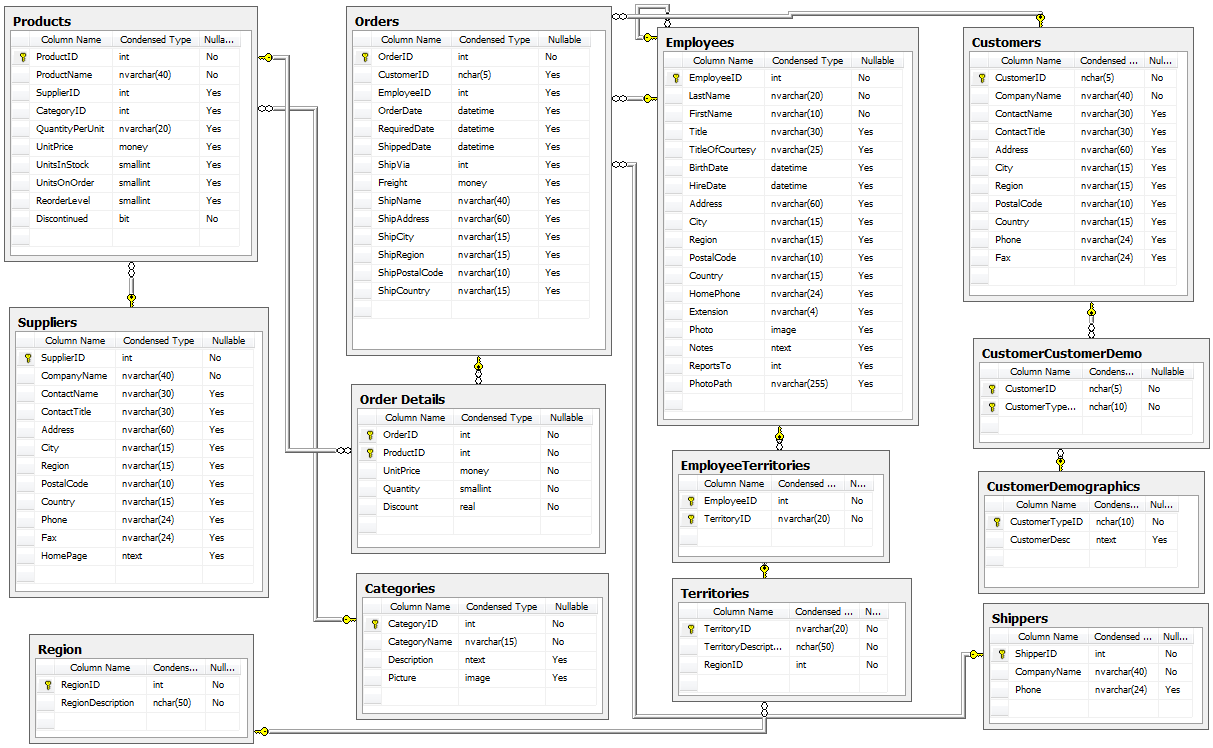

From the schema, we see that in order to answer this question, we require the fields `quantity` and `discount` from the `ORder Details` table.

In [4]:
# Define query
query = "SELECT Quantity, Discount FROM OrderDetail"

# Create dataframe based on query
df = pd.read_sql_query(query, engine)
df.head()

2020-12-28 10:30:53,460 INFO sqlalchemy.engine.base.Engine SELECT Quantity, Discount FROM OrderDetail
2020-12-28 10:30:53,461 INFO sqlalchemy.engine.base.Engine ()


,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


Let's investigate this DataFrame.

In [5]:
# Get number of rows
len(df)

2155

There are 2155 entries, each representing a product within an order.

In [6]:
# Check if any missing values
df.isna().any()

Quantity    False
Discount    False
dtype: bool

There do not appear to be any missing values, which is good.

In [7]:
# Get value counts
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

We see that the majority of entries were not subject to a discount. Popular levels of discount were 5%, 10%, 20%, 15% and 25% (in order of frequency observed.)

We will create a new binary column with 1 if there was a discount and 0 otherwise.

In [8]:
# Create binary column
df['Discount_binary'] = df['Discount'].map(lambda x: 1 if x > 0 else 0)

# Check
df.head()

,Quantity,Discount,Discount_binary
0,12,0.0,0
1,10,0.0,0
2,5,0.0,0
3,9,0.0,0
4,40,0.0,0


### Formulate hypothesis

**Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?**

Let us establish the null and alternative hypothesis.

**H<sub>0</sub>**: discounts have no effect on the number of products customers order. In other words, the average number of products ordered is the same with and without discount.

**H<sub>1</sub>**: discounts have a statistically significant effect on the number of products customers order. In other words, the average number of products ordered with a discount is either higher or lower than the number ordered without a discount.

We will set alpha to be 0.05.

### Visualisations

Let's visualise the total number of items ordered and average number of items ordered with and without discount to get an initial idea whether our alternate hypothesis may be true.

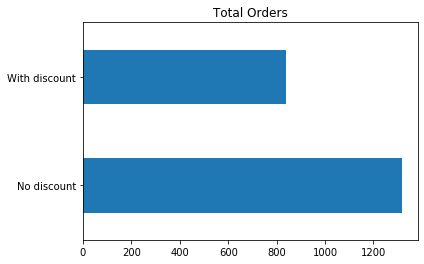

In [25]:
# Plot total orders with/without discount
df.groupby(['Discount_binary'])['Quantity'].count().plot(kind = 'barh')
plt.ylabel('')
plt.yticks((0,1),['No discount', 'With discount'])
plt.title('Total Orders')
plt.show()

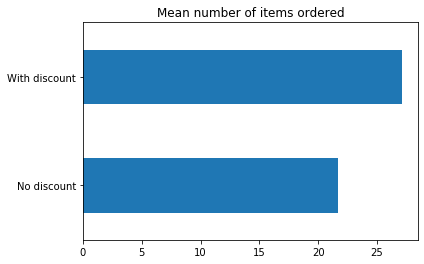

In [24]:
# Plot average num items ordered with/without discount
df.groupby(['Discount_binary'])['Quantity'].mean().plot(kind = 'barh')
plt.ylabel('')
plt.yticks((0,1),['No discount', 'With discount'])
plt.title('Mean number of items ordered')
plt.show()

The difference in average number of items ordered supports the alternate hypothesis that discounts have an effect on the quantity ordered.

### Hypothesis testing

To answer the question formally, we must use a statistical test. In this case we will use a **two-tailed t-test** as the data is continuous and we are looking for either a decrease or an increase in the quantity ordered.

A two-tail t-test assumes that the data is normally distributed and that the samples have equal variance. Let us check these assumptions by plotting the distribution.

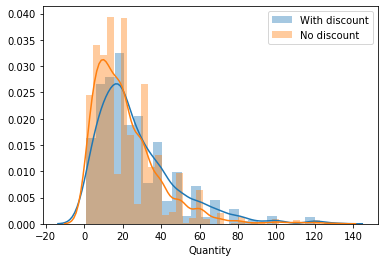

In [31]:
discount_df = df[df['Discount_binary']==1]
no_discount_df = df[df['Discount_binary']==0]

# Plot distributions
sns.distplot(discount_df['Quantity'], label = 'With discount')
sns.distplot(no_discount_df['Quantity'], label = 'No discount')
plt.legend()
plt.show()

We see that the distributions are positively skewed. However the data is overall normally distributed and we can use a standard t-test.

In [32]:
# Two-sided t-test
stats.ttest_ind(discount_df['Quantity'], no_discount_df['Quantity'])

Ttest_indResult(statistic=6.4785631962949015, pvalue=1.1440924523215966e-10)

The p-value is less than alpha of 0.05. 

We reject the null hypothesis H<sub>0</sub> and accept the alternative hypothesis H<sub>1</sub>. There is a statistically significant difference between the average quantity of items ordered with and without discount.

We now look at the second part of the question: **if so, at what levels of discount**.

We formulate a new null hypothesis and alternative hypothesis.

**H<sub>0</sub>**: the average number of products ordered is the same at various levels of discount

**H<sub>1</sub>**: the average number of products ordered is statistically different between the various levels of discount

Again, we will choose alpha to be 0.05.

As we are doing a multi-comparison, we will use ANOVA.

In [39]:
# Fit ANOVA table
lm = ols('Quantity ~ C(Discount)', discount_df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),6354.890405,9.0,1.647964,0.097673
Residual,354771.009356,828.0,NaN,NaN


In [40]:
# View model summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.648
Date:                Wed, 30 Dec 2020   Prob (F-statistic):             0.0977
Time:                        13:30:59   Log-Likelihood:                -3723.3
No. Observations:                 838   AIC:                             7467.
Df Residuals:                     828   BIC:                             7514.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.0000     20.699      0.097      0.923     -38.630      42.630
C(Discount)[T.0.02] -8.593e-14     25.352  -3.39e-15      1.000     -49.761      49.761
C(Discount)[T.0.03]    -0.3333     23.902     -0.014      0.989     -47.248      46.582
C(Discount)[T.0.04]    -1.0000     29.273     -0.034      0.973     -58.459      56.459
C(Discount)[T.0.05]    26.0108     20.755      1.253      0.210     -14.728      66.750
C(Discount)[T.0.06] -7.461e-14     29.273  -2.55e-15      1.000     -57.459      57.459
C(Discount)[T.0.1]     23.2370     20.759      1.119      0.263     -17.510      63.984
C(Discount)[T.0.15]    26.3822     20.765      1.270      0.204     -14.377      67.141
C(Discount)[T.0.2]     25.0248     20.764      1.205      0.228     -15.731      65.780
C(Discount)[T.0.25]    26.2403     20.767      1.264      0.207     -14.521      67.002
==============================================================================
Omnibus:                      268.493   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              777.012
Skew:                           1.606   Prob(JB):                    1.88e-169
Kurtosis:                       6.456   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see the p-values are above the threshold. As such we cannot reject the null hypothesis. 

No individual discount level has a statistically significant effect.

## Question 2

**Do discounts have a statistically significant effect on the amount a customer spends on their order?**

### Obtain and prepare data

In [41]:
# Define query
query = "SELECT OrderID, Quantity, UnitPrice, Discount FROM OrderDetail"

# Create dataframe based on query
df2 = pd.read_sql_query(query, engine)
df2.head()

2021-01-04 14:46:56,880 INFO sqlalchemy.engine.base.Engine SELECT OrderID, Quantity, UnitPrice, Discount FROM OrderDetail
2021-01-04 14:46:56,892 INFO sqlalchemy.engine.base.Engine ()


,OrderId,Quantity,UnitPrice,Discount
0,10248,12,14.0,0.0
1,10248,10,9.8,0.0
2,10248,5,34.8,0.0
3,10249,9,18.6,0.0
4,10249,40,42.4,0.0


Let's investigate this DataFrame.

In [42]:
# Get number of rows
len(df2)

2155

There are 2155 entries, each representing a product within an order.

In [43]:
# Get value counts
df2['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

We will create a new binary column with 1 if there was a discount and 0 otherwise.

In [44]:
# Create binary column
df2['Discount_binary'] = df2['Discount'].map(lambda x: 1 if x > 0 else 0)

# Check
df2.head()

,OrderId,Quantity,UnitPrice,Discount,Discount_binary
0,10248,12,14.0,0.0,0
1,10248,10,9.8,0.0,0
2,10248,5,34.8,0.0,0
3,10249,9,18.6,0.0,0
4,10249,40,42.4,0.0,0


We will also create an additional column, which calculates the total revenue for each order by multiplying the unit price by the quantity and taking into consideration the discount amount (if any).

In [45]:
# New column with revenue
df2['revenue'] = df2['Quantity'] * df2['UnitPrice'] * (1 - df2['Discount'])

In [46]:
# Drop columns for quantity and unit price as no longer needed
df2.drop(['Quantity', 'UnitPrice'], axis=1, inplace=True)

In [48]:
# Group by order and discount and then sum revenue, to get revenue per order
df2 = df2.groupby(['Discount_binary', 'Discount', 'OrderId'])['revenue'].sum().reset_index()

# Check
df2.head()

,Discount_binary,Discount,OrderId,revenue
0,0,0.0,10248,440.0
1,0,0.0,10249,1863.4
2,0,0.0,10250,77.0
3,0,0.0,10251,336.0
4,0,0.0,10252,1088.0


In [50]:
# Get num of rows
print(len(df2))

# Get num or unique orderIDs
print(df2['OrderId'].nunique())

1000
830


There are 830 unique orders but 1000 entries in our DataFrame. This is because some orders had items with different levels of discount in them. For simplicity we will drop these rows.

In [51]:
# Drop duplice OrderId rows
df2 = df2.drop_duplicates(subset=['OrderId'], keep=False)

In [52]:
# Get num of rows
len(df2)

667

We are left with 667 rows, representing 667 unique orders.

In [53]:
# Drop OrderID as no longer required
df2 = df2.drop('OrderId', axis = 1)

# Check
df2.head()

,Discount_binary,Discount,revenue
0,0,0.0,440.0
1,0,0.0,1863.4
5,0,0.0,1444.8
7,0,0.0,2490.5
8,0,0.0,517.8


### Formulate hypothesis

**Do discounts have a statistically significant effect on the amount a customer spends on their order?**

Let us establish the null and alternative hypothesis.

**H<sub>0</sub>**: discounts have no effect on the amount a customer spends. In other words, the average revenue per order is the same with and without discount

**H<sub>1</sub>**: discounts have a statistically significant effect on the amount a customer spends. In other words, the average revenue per order with a discount is either higher or lower than the average revenue without a discount.

We will set alpha to be 0.05.

### Visualisations

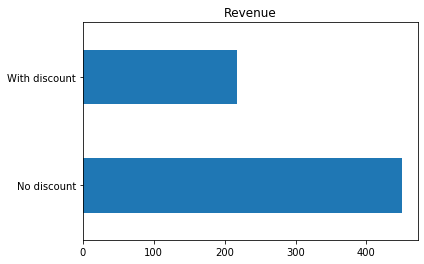

In [56]:
# Plot total revenue with/without discount
df2.groupby(['Discount_binary'])['revenue'].count().plot(kind = 'barh')
plt.ylabel('')
plt.yticks((0,1),['No discount', 'With discount'])
plt.title('Revenue')
plt.show()

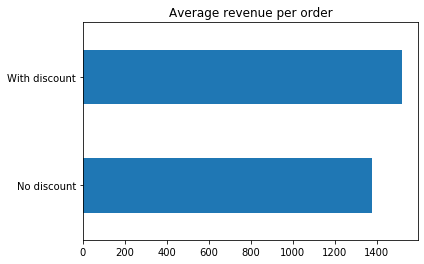

In [58]:
# Plot average revenue with/without discount
df2.groupby(['Discount_binary'])['revenue'].mean().plot(kind = 'barh')
plt.ylabel('')
plt.yticks((0,1),['No discount', 'With discount'])
plt.title('Average revenue per order')
plt.show()

The difference in average revenue per order supports the alternate hypothesis that discounts have an effect on the amount spent.

### Hypothesis testing

To answer the question formally, we must use a statistical test. In this case we will use a **two-tailed t-test** as the data is continuous and we are looking for either a decrease or an increase in the average revenue per order.

A two-tail t-test assumes that the data is normally distributed and that the samples have equal variance. Let us check these assumptions by plotting the distribution.

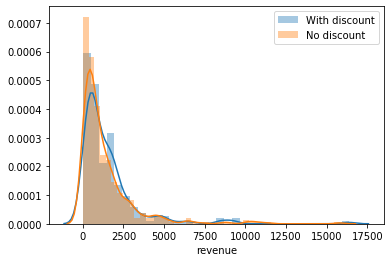

In [59]:
discount_df2 = df2[df2['Discount_binary']==1]
no_discount_df2 = df2[df2['Discount_binary']==0]

# Plot distributions
sns.distplot(discount_df2['revenue'], label = 'With discount')
sns.distplot(no_discount_df2['revenue'], label = 'No discount')
plt.legend()
plt.show()

We see that the distributions are heavily positively skewed, with long right tails. We will do a log-transformation.

In [61]:
# Create a copy
df2_log = df2.copy()

# Log transform revenue column
df2_log['revenue'] = df2_log['revenue'].map(lambda x: np.log(x))

# Check
df2_log.head()

,Discount_binary,Discount,revenue
0,0,0.0,6.086775
1,0,0.0,7.530158
5,0,0.0,7.275726
7,0,0.0,7.820239
8,0,0.0,6.249589


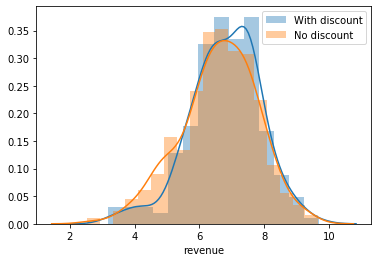

In [62]:
# Plot distributions
discount_df2_log = df2_log[df2_log['Discount_binary']==1]
no_discount_df2_log = df2_log[df2_log['Discount_binary']==0]

# Plot distributions
sns.distplot(discount_df2_log['revenue'], label = 'With discount')
sns.distplot(no_discount_df2_log['revenue'], label = 'No discount')
plt.legend()
plt.show()

The data now looks to be normally distributed.

In [63]:
# Two-sided t-test
stats.ttest_ind(discount_df2_log['revenue'], no_discount_df2_log['revenue'])

Ttest_indResult(statistic=2.025022744444036, pvalue=0.04326406148298754)

The p-value is 0.043, which is smaller than the chosen alpha value of 0.05. We can therefore reject the null hypothesis in favour of the alternative hypothesis. 

There is a statistically significant difference between the average revenue per order for orders placed with and without discounts.

We now look at the second part of the question: **if so, at what levels of discount**.

We formulate a new null hypothesis and alternative hypothesis.

**H<sub>0</sub>**: the average revenue per order is the same at various levels of discount

**H<sub>1</sub>**: the average revenue per order is statistically different between the various levels of discount

Again, we will choose alpha to be 0.05.

As we are doing a multi-comparison, we will use ANOVA.

In [65]:
# Fit ANOVA table
lm = ols('revenue ~ C(Discount)', discount_df2_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),5.109529,4.0,1.055928,0.379379
Residual,256.461656,212.0,NaN,NaN


In [66]:
# Model summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.056
Date:                Thu, 07 Jan 2021   Prob (F-statistic):              0.379
Time:                        10:48:54   Log-Likelihood:                -326.04
No. Observations:                 217   AIC:                             662.1
Df Residuals:                     212   BIC:                             679.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.0426      0.144     48.764      0.000       6.758       7.327
C(Discount)[T.0.1]     -0.3656      0.226     -1.617      0.107      -0.811       0.080
C(Discount)[T.0.15]    -0.3598      0.233     -1.542      0.125      -0.820       0.100
C(Discount)[T.0.2]     -0.3528      0.216     -1.635      0.104      -0.778       0.073
C(Discount)[T.0.25]    -0.2731      0.233     -1.170      0.243      -0.733       0.187
==============================================================================
Omnibus:                        8.926   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.931
Skew:                          -0.437   Prob(JB):                       0.0115
Kurtosis:                       3.474   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-values are above the alpha of 0.05. As such we cannot reject the null hypothesis.

## Question 3

**Does the average order amount vary significally between customers in different regions?**

### Obtain and prepare data

In [69]:
query = "SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount \
         FROM Customer c \
         JOIN [Order] o ON c.Id = o.CustomerId \
         JOIN OrderDetail od ON od.OrderId = o.Id"

In [70]:
df3 = pd.read_sql_query(query, engine )
df3.head()

2021-01-08 11:48:38,214 INFO sqlalchemy.engine.base.Engine SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount          FROM Customer c          JOIN [Order] o ON c.Id = o.CustomerId          JOIN OrderDetail od ON od.OrderId = o.Id
2021-01-08 11:48:38,215 INFO sqlalchemy.engine.base.Engine ()


,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


Let's investigate this DataFrame.

In [71]:
# Get number of rows
len(df3)

2078

In [72]:
# Get info
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 5 columns):
Region       2078 non-null object
OrderId      2078 non-null int64
Quantity     2078 non-null int64
UnitPrice    2078 non-null float64
Discount     2078 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 81.3+ KB


There do not appear to be any missing values.

In [73]:
# New column with revenue
df3['revenue'] = df3['Quantity'] * df3['UnitPrice'] * (1 - df3['Discount'])

In [74]:
# Drop columns for quantity, unit price and Discount as no longer needed
df3 = df3.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1)

In [75]:
# Group the data by order and sum the revenue for each order
df3 = df3.groupby(['Region', 'OrderId'])['revenue'].sum().reset_index()

In [76]:
# Drop OrderId column as no longer needed
df3 = df3.drop('OrderId', axis = 1)

In [77]:
# Check
df3.head()

,Region,revenue
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


Let us use `groupby` to count the number of orders in each region.

In [78]:
df3.groupby('Region').count()

,revenue
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


We note that some regions, such as `Eastern Europe` have a small number of orders. It is best to combine them in a way that makes geographical sense. ANOVA assumes equal variance between samples so it is best to ensure the samples are roughly of equal size.

In [81]:
# Combine Eastern Europe with Southern Europe
df3.loc[(df3['Region'] == 'Eastern Europe') | (df3['Region'] == 'Southern Europe')] = 'Southern and Eastern Europe'

# Combine Northern Europe Europe with Scandinavia
df3.loc[(df3['Region'] == 'Northern Europe') | (df3['Region'] == 'Scandinavia')] = 'Northern Europe and Scandinavia'

# Combine Central America with South America
df3.loc[(df3['Region'] == 'Central America') | (df3['Region'] == 'South America')] = 'South and Central Americal'

In [83]:
# Check
df3.groupby('Region').count()

,revenue
Region,
British Isles,75
North America,152
Northern Europe and Scandinavia,83
South and Central Americal,148
Southern and Eastern Europe,71
Western Europe,272


### Formulate hypothesis

**Does the average order amount vary significally between customers in different regions?**

Let us establish the null and alternative hypothesis.

**H<sub>0</sub>**: the average amount spent per order is the same between different regions

**H<sub>1</sub>**: the average amount spent per order is different - either higher or lower - between different regions.

We will set alpha to be 0.05.